# From Text to a Knowledge Graph

Based on article: *[From Text to a Knowledge Graph. Hands-on](https://medium.com/@hugojm/from-text-to-a-knowledge-graph-hands-on-dd68e9d42939)*

Libraries: 
* [DBpedia Spotlight for SpaCy](https://spacy.io/universe/project/spacy-dbpedia-spotlight): **pip install spacy_dbpedia_spotlight**
* [Getting started with RDFLib](https://rdflib.readthedocs.io/en/stable/gettingstarted.html): **conda install -c conda-forge rdflib**

In [ ]:
import spacy
import spacy_dbpedia_spotlight
from spacy.matcher import Matcher

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('dbpedia_spotlight')

<spacy_dbpedia_spotlight.entity_linker.EntityLinker>

In [ ]:
doc = nlp("Joe Biden married Jill Tracy Jacobs, who was educated at the University of Delaware")

## PreProcessament 

### Tokenisation

In [ ]:
print([token.text for token in doc], sep=' ')

['Joe', 'Biden', 'married', 'Jill', 'Tracy', 'Jacobs', ',', 'who', 'was', 'educated', 'at', 'the', 'University', 'of', 'Delaware']


### Lemmatisation

In [ ]:
print([token.lemma_ for token in doc], sep=' ')

['Joe', 'Biden', 'marry', 'Jill', 'Tracy', 'Jacobs', ',', 'who', 'be', 'educate', 'at', 'the', 'University', 'of', 'Delaware']


### Part-of-speech Tagging

In [ ]:
print([(token.lemma_, token.pos_) for token in doc], sep=' ')

[('Joe', 'PROPN'), ('Biden', 'PROPN'), ('marry', 'VERB'), ('Jill', 'PROPN'), ('Tracy', 'PROPN'), ('Jacobs', 'PROPN'), (',', 'PUNCT'), ('who', 'PRON'), ('be', 'AUX'), ('educate', 'VERB'), ('at', 'ADP'), ('the', 'DET'), ('University', 'PROPN'), ('of', 'ADP'), ('Delaware', 'PROPN')]


### Dependency Parsing

In [ ]:
print([(token.lemma_, token.dep_) for token in doc], sep=' ')

[('Joe', 'compound'), ('Biden', 'nsubj'), ('marry', 'ROOT'), ('Jill', 'compound'), ('Tracy', 'compound'), ('Jacobs', 'dobj'), (',', 'punct'), ('who', 'nsubjpass'), ('be', 'auxpass'), ('educate', 'relcl'), ('at', 'prep'), ('the', 'det'), ('University', 'pobj'), ('of', 'prep'), ('Delaware', 'pobj')]


In [ ]:
from spacy import displacy
displacy.render(doc, style="dep")

### Named Entity Recognition (NER)

In [ ]:
print([(ent.text, ent.label_) for ent in doc.ents], sep=' ')

[('Joe Biden', 'DBPEDIA_ENT'), ('Jill Tracy', 'DBPEDIA_ENT'), ('Delaware', 'DBPEDIA_ENT')]


In [ ]:
ents = [ent for ent in doc.ents]

In [ ]:
ents_t = [ent.text for ent in doc.ents]

In [ ]:
print("Before: ", [token.text for token in doc])

with doc.retokenize() as retokenizer:
    for i in range(len(ents)):
        retokenizer.merge(doc.ents[i])
print("After: ", [token.text for token in doc])

Before:  ['Joe', 'Biden', 'married', 'Jill', 'Tracy', 'Jacobs', ',', 'who', 'was', 'educated', 'at', 'the', 'University', 'of', 'Delaware']
After:  ['Joe Biden', 'married', 'Jill Tracy', 'Jacobs', ',', 'who', 'was', 'educated', 'at', 'the', 'University', 'of', 'Delaware']


### Named Entity Linking (NEL)

In [ ]:
print([ent.kb_id_ for ent in doc.ents])

['http://dbpedia.org/resource/Joe_Biden', 'http://dbpedia.org/resource/Jill_Tracy', 'http://dbpedia.org/resource/Delaware']


### Relation Extraction (RE)

In [ ]:
def get_relation(sent):
    aux = []
    doc = nlp(sent)
    
    # Matcher class object
    matcher = Matcher(nlp.vocab)
    
    # define the pattern
    pattern = [[{'DEP' : 'ROOT'}],[{'DEP':'RELCL'}], [{'POS': 'VERB'}]]
    
    matcher.add("matching_1", pattern)
    
    matches = matcher(doc)
    for x in matches:
        aux.append(doc[x[1]:x[2]].text)
        
    return(aux)

In [ ]:
rels = get_relation("Joe Biden married Jill Tracy Jacobs, who was educated at the University of Delaware")
print(rels)

['married', 'educated']


## Building Knowledge Graph

Finally we are going to create the final Knowledge Graph with the information we have.

In [ ]:
from rdflib import Graph, URIRef, Literal, BNode
from rdflib.namespace import RDF, RDFS
from rdflib import Namespace

In [ ]:
g = Graph()

for ent in doc.ents:
    # add the label of the entry
    g.add((URIRef(ent.kb_id_), RDFS.label, Literal(ent.text)))
    prev = URIRef(ent.kb_id_)
    
g.add((URIRef('http://dbpedia.org/resource/Joe_Biden'), URIRef("https://dbpedia.org/ontology/"+rels[0]), URIRef('http://dbpedia.org/resource/Jill_Tracy'))) 
g.add((URIRef('http://dbpedia.org/resource/Jill_Tracy'), URIRef("https://dbpedia.org/ontology/"+rels[1]), URIRef('http://dbpedia.org/resource/Delaware')))

<Graph identifier=N163a4688ebcf4acda406cdb26276550d (<class 'rdflib.graph.Graph'>)>

In [ ]:
for s,p, o in g:
    print(s,p,o)

http://dbpedia.org/resource/Joe_Biden https://dbpedia.org/ontology/married http://dbpedia.org/resource/Jill_Tracy
http://dbpedia.org/resource/Joe_Biden http://www.w3.org/2000/01/rdf-schema#label Joe Biden
http://dbpedia.org/resource/Jill_Tracy http://www.w3.org/2000/01/rdf-schema#label Jill Tracy
http://dbpedia.org/resource/Jill_Tracy https://dbpedia.org/ontology/educated http://dbpedia.org/resource/Delaware
http://dbpedia.org/resource/Delaware http://www.w3.org/2000/01/rdf-schema#label Delaware


## Visualizing the Knowledge Graph

TypeError: '_AxesStack' object is not callable

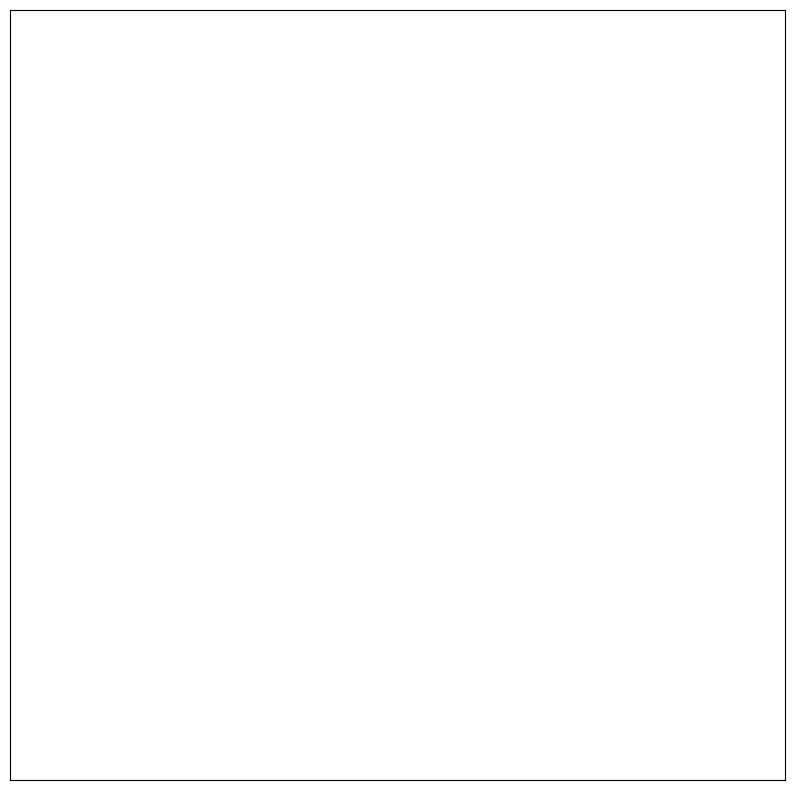

In [ ]:
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
#from networkx import cf
import matplotlib.pyplot as plt
%matplotlib inline

G = rdflib_to_networkx_multidigraph(g)

#  Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=2)
edge_labels = nx.get_edge_attributes(G, 'r')
plt.figure(figsize=(10,10))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, with_labels=True)

plt.show()